In [2]:
import pandas as pd
import os
import numpy as np
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from scipy.stats import levene
from scipy.stats import kruskal
import pingouin as pg

In [3]:
# file load & merge
directory_path = './final_prpdata_1st/'
file_names = [f for f in os.listdir(directory_path) if f.endswith('.csv')]
file_names = sorted(file_names)
dataframes = [pd.read_csv(os.path.join(directory_path, file_name)) for file_name in file_names]

df_prpdata_all = pd.concat(dataframes, ignore_index=True)
file_names

['df_prp_f_0.csv',
 'df_prp_f_1.csv',
 'df_prp_f_2.csv',
 'df_prp_f_3.csv',
 'df_prp_f_4.csv',
 'df_prp_f_5.csv',
 'df_prp_f_6.csv',
 'df_prp_f_7.csv',
 'df_prp_f_8.csv']

In [4]:
# f_mode 컬럼 추가
df = df_prpdata_all.copy()
conditions = [
    (df['hpt_yn'] == 1) & (df['lpt_yn'] == 0) & (df['fan_yn'] == 0) & (df['hpc_yn'] == 0) & (df['lpc_yn'] == 0),
    (df['hpt_yn'] == 1) & (df['lpt_yn'] == 1) & (df['fan_yn'] == 0) & (df['hpc_yn'] == 0) & (df['lpc_yn'] == 0),
    (df['hpt_yn'] == 0) & (df['lpt_yn'] == 0) & (df['fan_yn'] == 1) & (df['hpc_yn'] == 0) & (df['lpc_yn'] == 0),
    (df['hpt_yn'] == 0) & (df['lpt_yn'] == 0) & (df['fan_yn'] == 0) & (df['hpc_yn'] == 1) & (df['lpc_yn'] == 0),
    (df['hpt_yn'] == 0) & (df['lpt_yn'] == 0) & (df['fan_yn'] == 0) & (df['hpc_yn'] == 1) & (df['lpc_yn'] == 1),
    (df['hpt_yn'] == 0) & (df['lpt_yn'] == 1) & (df['fan_yn'] == 0) & (df['hpc_yn'] == 0) & (df['lpc_yn'] == 0),
    (df['hpt_yn'] == 1) & (df['lpt_yn'] == 1) & (df['fan_yn'] == 1) & (df['hpc_yn'] == 1) & (df['lpc_yn'] == 1),
    (df['hpt_yn'] == 0) & (df['lpt_yn'] == 0) & (df['fan_yn'] == 0) & (df['hpc_yn'] == 0) & (df['lpc_yn'] == 0),
]

failurMode = ['hpt', 'hpt+lpt', 'fan', 'hpc', 'hpc+lpc', 'lpt', 'all', 'healthy']

df["f_mode"] = np.select(conditions, failurMode, default='None')

print(df.shape)
print(df["f_mode"].shape)
print(df["f_mode"].unique())

df.to_csv("df_prpdata_merge.csv")

(7473, 536)
(7473,)
['healthy' 'hpt' 'hpt+lpt' 'fan' 'hpc' 'hpc+lpc' 'lpt' 'all']


In [8]:
# feature 준비(normalization)
data = df.copy()
colsToDrop = [col for col in data.columns if '_median' in col or '_RUL' in col]
# colsToDrop = [col for col in data.columns if '_RUL' in col]
dataCruiseClimb = data.drop(colsToDrop, axis=1)

features = dataCruiseClimb.drop(['hpt_yn', 'lpt_yn', 'fan_yn', 'hpc_yn', 'lpc_yn',
                      'hpt_yn_shift1', 'lpt_yn_shift1', 'fan_yn_shift1',
                      'hpc_yn_shift1', 'lpc_yn_shift1', 'f_mode', 'cycle', 'unit'], axis=1)

# Feature 정규화 (Min-Max Scaling)
scaler = MinMaxScaler()
normalizedFeatures = scaler.fit_transform(features)

# 정규화된 Feature 데이터프레임 생성
normalizedData = pd.DataFrame(normalizedFeatures, columns=features.columns)

# Failure_mode에 따른 feature 그룹 나누기 (예시)
failureModes = [normalizedData[df['f_mode'] == mode] for mode in failurMode]

In [9]:
# feature 별 동일한 분산 가지고 있는지 검정
# 각 feature에 대해 Levene test 실행
nonSameVarColumnList = []
for column in normalizedData.columns:
    groups = [mode[column] for mode in failureModes]
    stat, p_value = levene(*groups)
    
    if p_value < 0.05:
        nonSameVarColumnList.append(column)
print("The variances not equal across the groups based on Levene's test.")
print(str(len(nonSameVarColumnList))+" / "+str(len(normalizedData.columns)))

The variances not equal across the groups based on Levene's test.
368 / 418


In [6]:
# normalizedData.columns와 non_column_list를 각각 set으로 변환
columnsSet = set(normalizedData.columns)
nonSameVarColumnsSet = set(nonSameVarColumnList)
# 두 세트의 차집합 계산
differenceColSet = columnsSet - nonSameVarColumnsSet
# 결과 출력
print(len(differenceColSet))
differenceColSet


52


{'climb_fan_exit_press_max',
 'climb_hpc_entry_temp_std',
 'climb_hpc_exit_press_max',
 'climb_hpt_hpc_temp_min',
 'cruise_Mach_min',
 'cruise_Nf_median',
 'cruise_P24_std',
 'cruise_P30_max',
 'cruise_P30_std',
 'cruise_P40_max',
 'cruise_P40_std',
 'cruise_P45_max',
 'cruise_P45_std',
 'cruise_P50_std',
 'cruise_Ps30_max',
 'cruise_Ps30_std',
 'cruise_T24_max',
 'cruise_T24_std',
 'cruise_T50_max',
 'cruise_TRA_std',
 'cruise_W21_std',
 'cruise_W22_max',
 'cruise_W22_std',
 'cruise_W25_max',
 'cruise_W25_std',
 'cruise_W31_max',
 'cruise_W31_std',
 'cruise_W32_max',
 'cruise_W32_std',
 'cruise_W48_max',
 'cruise_W48_std',
 'cruise_W50_max',
 'cruise_W50_std',
 'cruise_Wf_std',
 'cruise_alt_std',
 'cruise_fan_exit_press_median',
 'cruise_hpc_entry_temp_std',
 'cruise_hpc_exit_press_min',
 'cruise_hpc_lpc_temp_ratio_std',
 'cruise_hpc_lpc_temp_std',
 'cruise_hpt_entry_press_ratio_std',
 'cruise_hpt_hpc_press_ratio_std',
 'cruise_hpt_hpc_press_std',
 'cruise_hpt_hpc_temp_ratio_std',
 'c

/var/folders/7d/d1khjvv95fs1dx3zplr2sfzh0000gn/T/ipykernel_2610/1994750128.py:20: RuntimeWarning: divide by zero encountered in log10
  log_p_values = -np.log10(p_values)


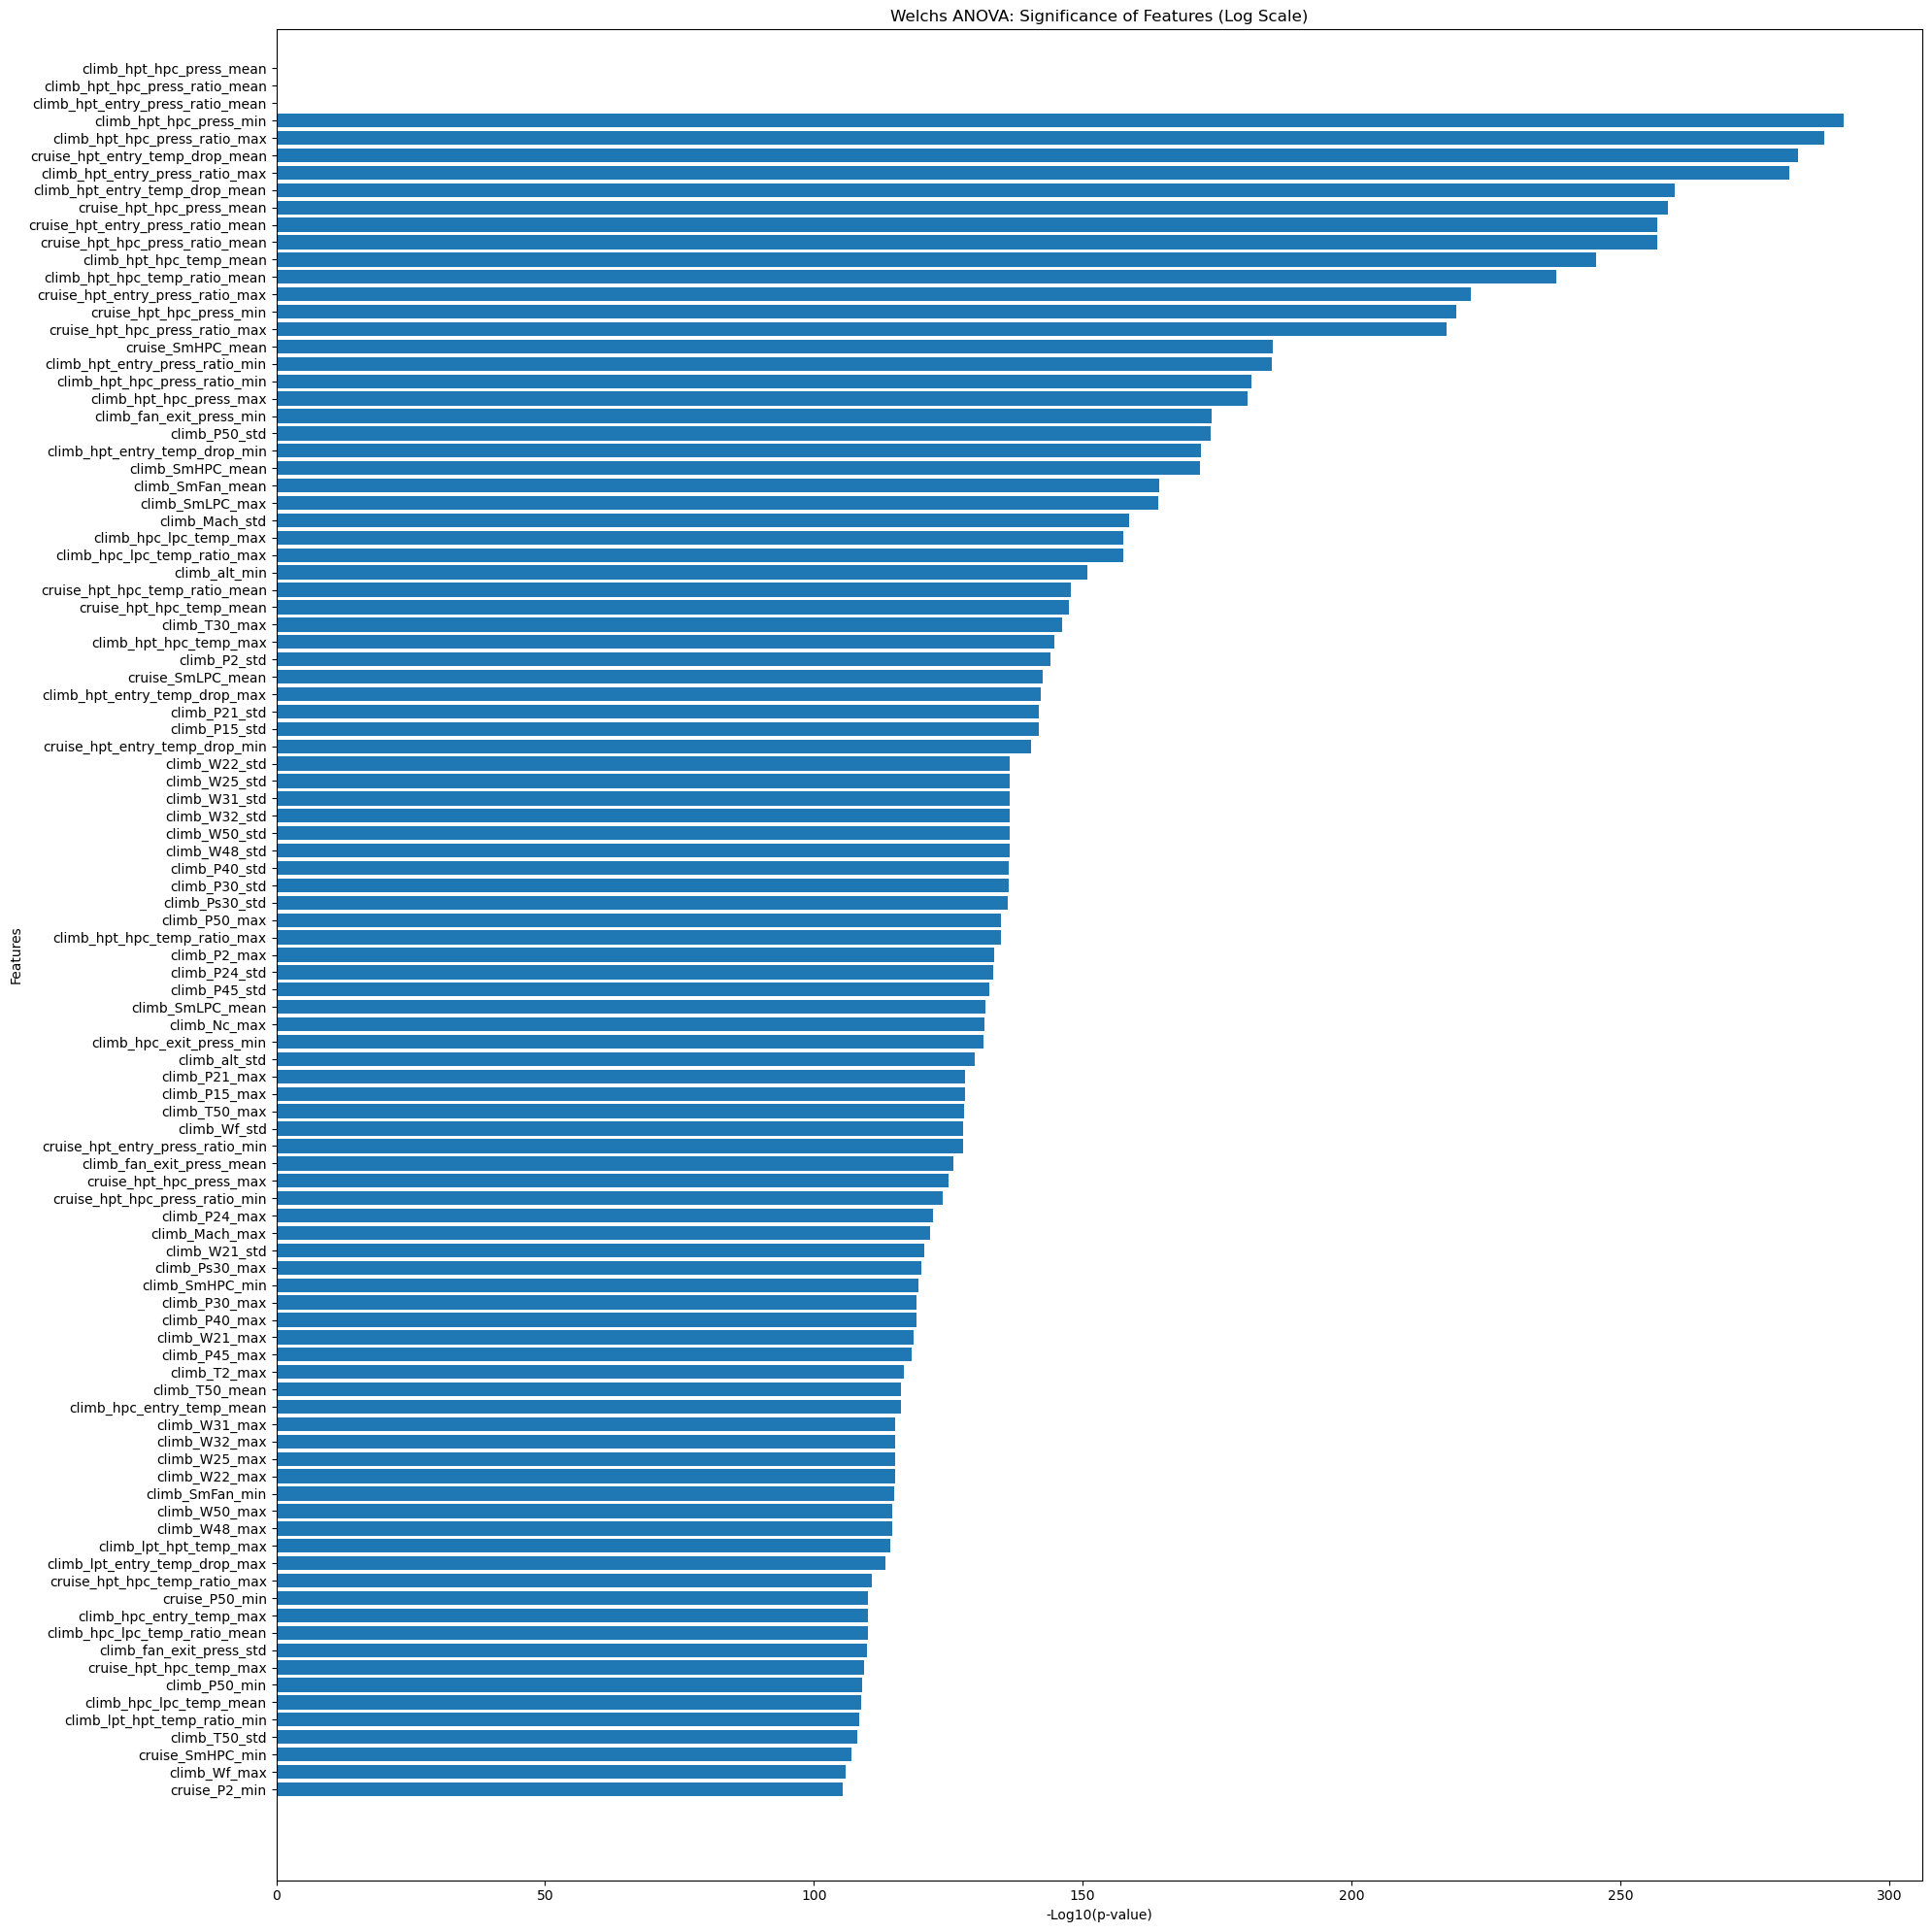

                             Feature     p-value
99                     cruise_P2_min  105.426501
98                      climb_Wf_max  105.933340
97                  cruise_SmHPC_min  106.950127
96                     climb_T50_std  108.107587
95      climb_lpt_hpt_temp_ratio_min  108.474272
..                               ...         ...
4      climb_hpt_hpc_press_ratio_max  287.838172
3            climb_hpt_hpc_press_min  291.582743
2   climb_hpt_entry_press_ratio_mean         inf
1     climb_hpt_hpc_press_ratio_mean         inf
0           climb_hpt_hpc_press_mean         inf

[100 rows x 2 columns]


In [10]:
# Welch's ANOVA test Best100
p_values = []
for column in normalizedData.columns:
    # 실패 모드별 데이터를 하나의 DataFrame으로 결합
    data_for_test = pd.concat([mode[[column]].assign(FailureMode=i) for i, mode in enumerate(failureModes)], ignore_index=True)

    # Welch's ANOVA 실행
    aov = pg.welch_anova(dv=column, between='FailureMode', data=data_for_test)
    p_value = aov['p-unc'][0]
    p_values.append((column, p_value))

# p-value 기준으로 정렬하여 상위 N개의 feature 선택 (예시에서는 N=30)
selectedFeatures = sorted(p_values, key=lambda x: x[1])[0:100]

# 그래프 생성
featureNames = [feature[0] for feature in selectedFeatures]
p_values     = [feature[1] for feature in selectedFeatures]

# p-value 값을 로그 스케일로 변환
log_p_values = -np.log10(p_values)

plt.figure(figsize=(20,20))
plt.barh(featureNames[::-1], log_p_values[::-1]) # 역순으로 표시하여 가장 유의미한 것부터 출력
plt.xlabel('-Log10(p-value)')
plt.ylabel('Features')
plt.title('Welchs ANOVA: Significance of Features (Log Scale)')
plt.tight_layout()
plt.show()

# 특성 이름과 p-value를 DataFrame으로 변환
df_features = pd.DataFrame(list(zip(featureNames, log_p_values)), columns=['Feature', 'p-value'])

# 역순으로 정렬하여 가장 유의미한 것부터 출력
df_features = df_features.sort_values(by='p-value', ascending=True)

# 결과 출력
print(df_features)


/var/folders/7d/d1khjvv95fs1dx3zplr2sfzh0000gn/T/ipykernel_2610/2383774353.py:20: RuntimeWarning: divide by zero encountered in log10
  log_p_values = -np.log10(p_values)


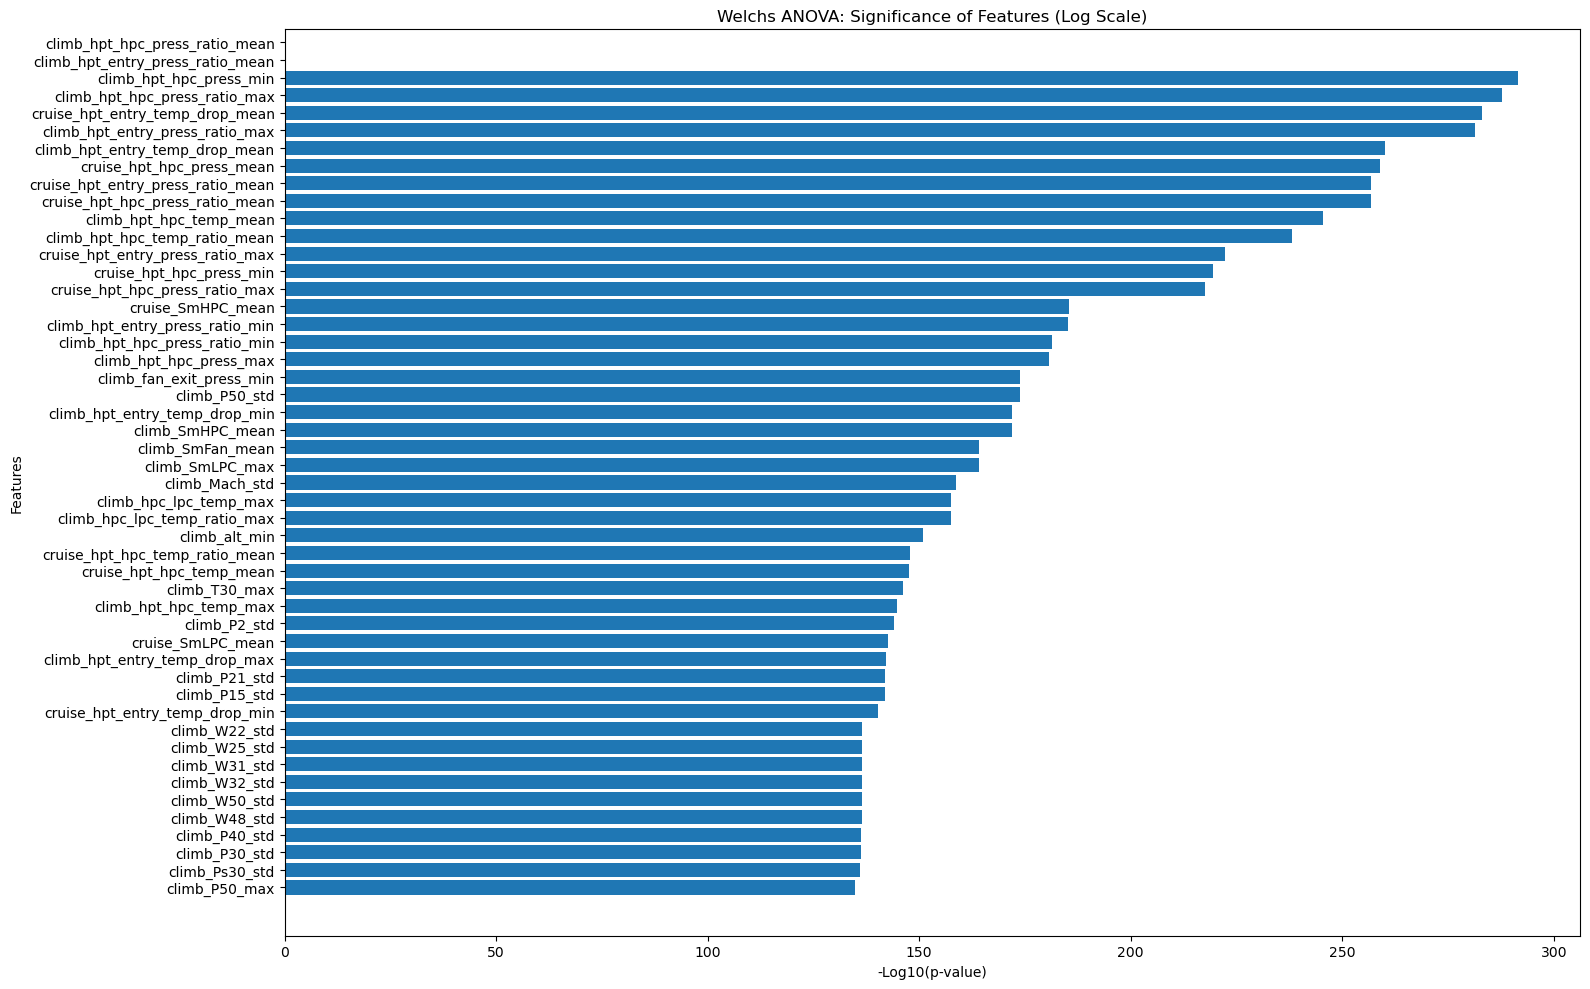

                              Feature     p-value
49                      climb_P50_max  134.870696
48                     climb_Ps30_std  136.038237
47                      climb_P30_std  136.173884
46                      climb_P40_std  136.175940
45                      climb_W48_std  136.395111
44                      climb_W50_std  136.402070
43                      climb_W32_std  136.490562
42                      climb_W31_std  136.490562
41                      climb_W25_std  136.490562
40                      climb_W22_std  136.490865
39     cruise_hpt_entry_temp_drop_min  140.349997
38                      climb_P15_std  141.860987
37                      climb_P21_std  141.862376
36      climb_hpt_entry_temp_drop_max  142.209204
35                  cruise_SmLPC_mean  142.577754
34                       climb_P2_std  143.944737
33             climb_hpt_hpc_temp_max  144.733106
32                      climb_T30_max  146.197098
31           cruise_hpt_hpc_temp_mean  147.517769


In [17]:
# Welch's ANOVA test Best30
p_values = []
for column in normalizedData.columns:
    # 실패 모드별 데이터를 하나의 DataFrame으로 결합
    data_for_test = pd.concat([mode[[column]].assign(FailureMode=i) for i, mode in enumerate(failureModes)], ignore_index=True)

    # Welch's ANOVA 실행
    aov = pg.welch_anova(dv=column, between='FailureMode', data=data_for_test)
    p_value = aov['p-unc'][0]
    p_values.append((column, p_value))

# p-value 기준으로 정렬하여 상위 N개의 feature 선택 (예시에서는 N=30)
selectedFeatures = sorted(p_values, key=lambda x: x[1])[0:50]

# 그래프 생성
featureNamesBest30WANOVA = [feature[0] for feature in selectedFeatures]
p_values     = [feature[1] for feature in selectedFeatures]

# p-value 값을 로그 스케일로 변환
log_p_values = -np.log10(p_values)

plt.figure(figsize=(16,10))
plt.barh(featureNamesBest30WANOVA[::-1], log_p_values[::-1]) # 역순으로 표시하여 가장 유의미한 것부터 출력
plt.xlabel('-Log10(p-value)')
plt.ylabel('Features')
plt.title('Welchs ANOVA: Significance of Features (Log Scale)')
plt.tight_layout()
plt.show()

# 특성 이름과 p-value를 DataFrame으로 변환
df_features = pd.DataFrame(list(zip(featureNamesBest30WANOVA, log_p_values)), columns=['Feature', 'p-value'])

# 역순으로 정렬하여 가장 유의미한 것부터 출력
df_features = df_features.sort_values(by='p-value', ascending=True)

# 결과 출력
print(df_features)

In [14]:
# normalizedData.columns와 non_column_list를 각각 set으로 변환
Best30columnsSet = set(featureNamesBest30WANOVA)
nonSameVarColumnsSet = set(nonSameVarColumnList)
# 두 세트의 차집합 계산
Best30SameVarSet = Best30columnsSet - nonSameVarColumnsSet
# 동일 분산 feature 결과 출력
print(len(Best30SameVarSet))
print(Best30SameVarSet)

0
set()


In [15]:
print(len(featureNamesBest30WANOVA))
featureNamesBest30WANOVA

50


['climb_hpt_hpc_press_mean',
 'climb_hpt_hpc_press_ratio_mean',
 'climb_hpt_entry_press_ratio_mean',
 'climb_hpt_hpc_press_min',
 'climb_hpt_hpc_press_ratio_max',
 'cruise_hpt_entry_temp_drop_mean',
 'climb_hpt_entry_press_ratio_max',
 'climb_hpt_entry_temp_drop_mean',
 'cruise_hpt_hpc_press_mean',
 'cruise_hpt_entry_press_ratio_mean',
 'cruise_hpt_hpc_press_ratio_mean',
 'climb_hpt_hpc_temp_mean',
 'climb_hpt_hpc_temp_ratio_mean',
 'cruise_hpt_entry_press_ratio_max',
 'cruise_hpt_hpc_press_min',
 'cruise_hpt_hpc_press_ratio_max',
 'cruise_SmHPC_mean',
 'climb_hpt_entry_press_ratio_min',
 'climb_hpt_hpc_press_ratio_min',
 'climb_hpt_hpc_press_max',
 'climb_fan_exit_press_min',
 'climb_P50_std',
 'climb_hpt_entry_temp_drop_min',
 'climb_SmHPC_mean',
 'climb_SmFan_mean',
 'climb_SmLPC_max',
 'climb_Mach_std',
 'climb_hpc_lpc_temp_max',
 'climb_hpc_lpc_temp_ratio_max',
 'climb_alt_min',
 'cruise_hpt_hpc_temp_ratio_mean',
 'cruise_hpt_hpc_temp_mean',
 'climb_T30_max',
 'climb_hpt_hpc_temp_